# Curve Fitting: Exponential Decay

In this example we will fit a simple exponential decay model to a timeseries of decreasing surface soil water content.

## Intuition

After a large rainfall event the soil surface becomes wet reaching values near saturation. Saturation simply means that the pores spaces in the soil are filled with water rather than air. From this point the soil starts losing water by drainage, evaporation, and root water uptake. As a consequence, and assuming no additional rainfal, the soil becomes drier with every day that goes by. However, because of adhesive forces between water molecules and soil particles, it becomes increasingly harder for the soil to lose water. At moderate to low moisture contents the soil water is mostly lost from the soil in the form of vapor due to the process of evaporation. Very little is lost due to drainage or even root water uptake. Thus, the rate of water loss is reduced, to an extreme where the rate of water loss becomes nearly zero and the soil water content remains constant.

This process can be approximated using an exponential decay type of equation. Several studies have used this approach to test the drying rate of the soil surface from dedicated satellite mission that measure soil moisture.

## An exponential decay model

One of the many variations of this model is the following:

$$\theta = A \; exp\Bigg(\frac{t}{\tau}\Bigg) + \theta_f$$

$\theta$ = Volumetric water content in (cm<sup>3</sup> cm<sup>-3</sup>)

$t$ is time since beginning of the drydown (days)

$A$ represents the initial water content of the drydown period

$\tau$ is related to the rate of water loss and changes the concavity of the curve

$\theta_f$ is the asymptotic volumetric water content approached by the curve under a prolongued period without rainfall.

$A$, $\tau$, and $\theta_f$ are empirical parameters determined by fitting observed data

## Dataset

The data set consists of a timeseries of voluemtric water content ($\theta$) at 5-cm depth observed at the Gypsum station of the Kansas Mesonet. The drydown started on 1-jul-2017 (DOY=182)after a substantial rainfall event that was able to moisten the top soil and lasted for about 47 days. The drydown ended around 16-aug-2017 (DOY=228). There were no appreciable rainfall events during the drydown period.

The dataset is in file names `gypsum_ks_drydown_2017.csv` contained in the the `Datasets` folder.


## Problem

The first step is to import a tentative list of modules that we need to solve the problem. We will load the usual modules to handle tabular data. The key module to perform the fitting routine is called `curve_fit` and is located in the `scipy.optimize` module.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

In [2]:
data = pd.read_csv('/Users/andrespatrignani/Dropbox/Teaching/Scientific programming/introcoding-spring-2019/Datasets/gypsum_ks_drydown_2017.csv')
data.head(5)

,day_of_the_year,volumetric_water_content
0,182,0.3766
1,183,0.3518
2,184,0.3284
3,185,0.3121
4,186,0.2926


To handle the x (day of the year) and y (soil water content) data with shorter and more intuitive names during the curve fitting process we will store these variables into `xdata` and `ydata`. 

Here we need to clarify two points:

1. The model requires days since the beginning of the drydown. Because the dataset contains days of the year we will need to re-adjust the values so that we start the drydown from day 0.

2. We will also also convert the volumetric water content into percentage so that is a bit easier to read. For instance, a volumetric water content of 20% means that 20% of a given volume of soil is occupied by water.

In [31]:
xdata = data.day_of_the_year - data.day_of_the_year[0]
ydata = data.volumetric_water_content*100

It's always a good idea to visualize our dataset. We will throw some labels for completeness.

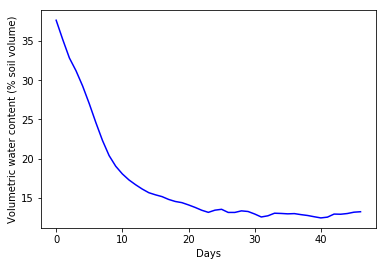

In [44]:
plt.plot(xdata, ydata, 'b-', label='obs')
plt.xlabel('Days')
plt.ylabel('Volumetric water content (% soil volume)')
plt.show()

Next step is about defining the model. We can use a traditional Python function or a lambda function. We will use the latter since this a rather simple model that we can fit in one line of code.

In [33]:
model = lambda x,a,b,c: a * np.exp(-x/b) + c

It's time to fit the model to our data. Our goal is to obtained the best unbiased parameter values for our model. Remember that in the model description we said that there were three parameters that are determined empirically? This is step where we do that.

The `curve_fit` functions is stright forward. We pass the `model`, then the `xdata`, and lastly the `ydata`. We can add some restrictions to the range of the parameters, but we will do that later to keep the problem a bit simpler for now.

In [34]:
# Fit parameters
par_opt, par_cov = curve_fit(model, xdata, ydata)
print(par_opt)


[26.63116598  6.94644223 12.58195859]


We can also estimate the standard deviation of each parameter by taking the square root of the variance of each parameter. The diagonal of the covariance matrix is simply the variance. So if we take the square root of the variance we end up with the standard deviation. Hope you remember basic statistics! Numpy functions become handy here since we can use `np.diag` and `np.sqrt` to make this step easy.

In [47]:
par_err = np.sqrt(np.diag(par_cov)) # One standard deviation
print(par_err)

[0.39435232 0.20168343 0.13383765]


Done! It just took couple lines of code. The only thing that remains to be done is to plot the model with the optimize parameters and compare the fitted model with the observed data.

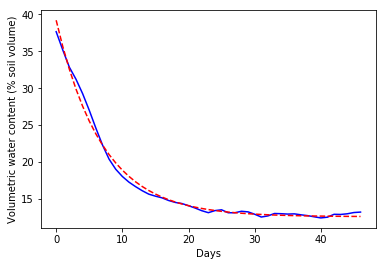

In [49]:
# Plot observed and fitted curves
plt.plot(xdata, ydata, 'b-')
plt.plot(xdata, model(xdata, *par_opt), '--r')
plt.xlabel('Days')
plt.ylabel('Volumetric water content (% soil volume)')
plt.show()

In this particular case some of the parameters have physical meaning. For instance $\theta_f$ represents the asymptotic value appraoched by the soil water content. The value for this parameter can certainly not be negative, as negative soil water content would be unrealistic. If the soil does not receive any rainfall for a long period the soil will eventually dry out reaching a value of zero volumetric water content, but it cannot get lower than that. So it might be good if we can inform the `curve_fit` routine about lower and upper boundaries that we woudl like to enforce. We can do this using the `bounds` options. Here are some approaximate bounds (setting appropriate bounds will require some experience with the model and the range of the properties represented by the model parameters):

`0%` <= $A$ <= `50%` (between completely dry and saturated soil)

`0%` <= $\tau$ <= `30%` (these values are just rough guess)

`0%` <= $\theta_f$ <= `20%` (between completely dry and a ballpark asymptote)

In [50]:
lb = [0,0,0]
ub = [45,30,20]
par_opt_bounded, par_cov_bounded = curve_fit(model, xdata, ydata, bounds=(lb, ub))
par_opt_bounded

array([26.63116185,  6.94644701, 12.58195656])

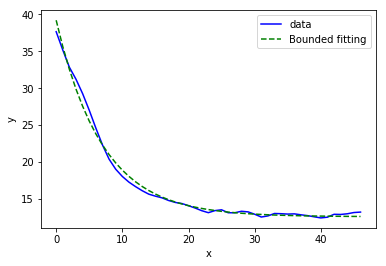

In [51]:
plt.plot(xdata, ydata, 'b-', label='data')
plt.plot(xdata, func(xdata, *par_opt_bounded), 'g--',label='Bounded fitting')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## References
Shellito, P.J., Small, E.E., Colliander, A., Bindlish, R., Cosh, M.H., Berg, A.A., Bosch, D.D., Caldwell, T.G., Goodrich, D.C., McNairn, H. and Prueger, J.H., 2016. SMAP soil moisture drying more rapid than observed in situ following rainfall events. Geophysical research letters, 43(15), pp.8068-8075.